<a href="https://colab.research.google.com/github/Vamsi-Malineni/Research-work/blob/master/tests5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install sciann

     |████████████████████████████████| 173 kB 5.2 MB/s 
     |████████████████████████████████| 561 kB 40.7 MB/s 
     |████████████████████████████████| 460.3 MB 8.5 kB/s 
     |████████████████████████████████| 462 kB 47.4 MB/s 
     |████████████████████████████████| 132 kB 47.5 MB/s 
     |████████████████████████████████| 4.0 MB 36.1 MB/s 
     |████████████████████████████████| 1.2 MB 40.2 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68716 sha256=f541cad60ef801d7a4a83670d8ccc86083886f3fd90c3328a462dacc3e5bed84
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.43.0
    Uninstalling gr

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import sciann as sn

---------------------- SCIANN 0.6.5.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.5.3 
Python Version: 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0] 



In [4]:
def prepdata(num,random=True):
    path=r"E:\Research work\Simulations and data\Unsteady trials\data\trials\cyl_pap"
    data = scipy.io.loadmat("/content/drive/MyDrive/data.mat")
    
    
    UU=data['uvel']
    VV=data['vvel']
    PP=data['press']
    xy=data['xy']
    t=data['time']
    
    N=xy.shape[0]
    T=t.shape[0]
    XX = np.tile(xy[:,0:1], (1,T)) # N x T
    YY = np.tile(xy[:,1:2], (1,T)) # N x T
    TT = np.tile(t, (1,N)).T # N x T
    
    if random:
        idx = np.random.choice(N*T, num, replace=False)
        #print(idx.shape)
    else:
        idx = np.arange(0, N*T)
    
    x = XX.flatten()[idx,None] # NT x 1
    y = YY.flatten()[idx,None] # NT x 1
    t = TT.flatten()[idx,None] # NT x 1
    
    u = UU.flatten()[idx,None] # NT x 1
    v = VV.flatten()[idx,None] # NT x 1
    p = PP.flatten()[idx,None] # NT x 1
    
    return (x,y,t,u,v,p)
   

In [5]:
x_train,y_train,t_train,u_train,v_train,p_train=prepdata(20000,random=True)


In [6]:
print(x_train.shape)

(20000, 1)


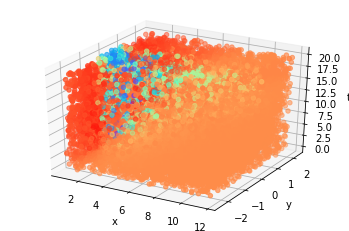

In [7]:
ax = plt.axes(projection ='3d')
ax.scatter3D(x_train, y_train,t_train,c=u_train,cmap='rainbow')
ax.set_title('')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
plt.show()

In [8]:
x = sn.Variable("x", dtype='float64')
y = sn.Variable("y", dtype='float64')
t = sn.Variable("t", dtype='float64')

In [9]:
P = sn.Functional("P", [x, y, t], [20, 20, 20, 20, 20, 20, 20, 20, 20], 'tanh')
Psi = sn.Functional("Psi", [x, y, t], [20, 20, 20, 20, 20, 20, 20, 20, 20], 'tanh')

In [10]:
lambda1 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda1")
lambda2 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda2")

In [11]:
u = sn.diff(Psi, y)
v = -sn.diff(Psi, x)

u_t = sn.diff(u, t)
u_x = sn.diff(u, x)
u_y = sn.diff(u, y)
u_xx = sn.diff(u, x, order=2)
u_yy = sn.diff(u, y, order=2)

v_t = sn.diff(v, t)
v_x = sn.diff(v, x)
v_y = sn.diff(v, y)
v_xx = sn.diff(v, x, order=2)
v_yy = sn.diff(v, y, order=2)

p_x = sn.diff(P, x)
p_y = sn.diff(P, y)

In [12]:
# Define constraints 
d1 = sn.Data(u,name='data')
d2 = sn.Data(v,name='data')
d3 = sn.Data(P,name='data')

c1 = sn.Tie(-p_x, u_t+lambda1*(u*u_x+v*u_y)-lambda2*(u_xx+u_yy))
c2 = sn.Tie(-p_y, v_t+lambda1*(u*v_x+v*v_y)-lambda2*(v_xx+v_yy))
c3 = sn.Data(u_x + v_y)


In [13]:
c4 = Psi*0.0


In [14]:
model = sn.SciModel(
    inputs=[x, y, t],
    targets=[d1, d2, d3, c1, c2, c3, c4],
    loss_func="mse"
)

In [15]:
input_data = [x_train, y_train, t_train]


In [16]:
data_d1 = u_train
data_d2 = v_train
data_d3 = p_train
data_c1 = 'zeros'
data_c2 = 'zeros'
data_c3 = 'zeros'
data_c4 = 'zeros'
target_data = [data_d1, data_d2, data_d3, data_c1, data_c2, data_c3, data_c4]

In [17]:
history = model.train(
    x_true=input_data,
    y_true=target_data,
    epochs=100,
    batch_size=50,
    shuffle=True,
    learning_rate=0.001,
    reduce_lr_after=100,
    stop_loss_value=1e-8,
    verbose=1
)



Total samples: 20000 
Batch size: 50 
Total batches: 400 

Epoch 1/100
400/400 [==============================] - 118s 207ms/step - batch: 199.5000 - size: 50.0000 - loss: 0.1825 - Grad__loss: 0.1275 - mul_loss: 0.0132 - P_loss: 0.0273 - sub_2_loss: 0.0105 - sub_4_loss: 0.0041 - add_7_loss: 3.3661e-33 - mul_12_loss: 0.0000e+00 - lr: 0.0010 - time: 118.0981
Epoch 2/100
400/400 [==============================] - 78s 194ms/step - batch: 199.5000 - size: 50.0000 - loss: 0.0373 - Grad__loss: 0.0102 - mul_loss: 0.0026 - P_loss: 0.0178 - sub_2_loss: 0.0013 - sub_4_loss: 0.0054 - add_7_loss: 4.3420e-33 - mul_12_loss: 0.0000e+00 - lr: 0.0010 - time: 77.5181
Epoch 3/100
400/400 [==============================] - 77s 191ms/step - batch: 199.5000 - size: 50.0000 - loss: 0.0292 - Grad__loss: 0.0046 - mul_loss: 0.0015 - P_loss: 0.0168 - sub_2_loss: 8.2097e-04 - sub_4_loss: 0.0054 - add_7_loss: 4.4536e-33 - mul_12_loss: 0.0000e+00 - lr: 0.0010 - time: 76.5636
Epoch 4/100
400/400 [===================

In [18]:
print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))


lambda1: [1.59287376],  lambda2: [0.03255578]


In [ ]:
print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))


lambda1: [1.49804222],  lambda2: [0.0280817]


Text(0, 0.5, 'loss')

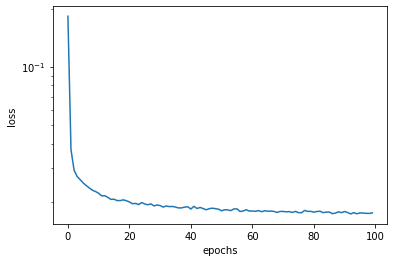

In [19]:
plt.semilogy(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [20]:
x_test,y_test,t_test,u_test,v_test,p_test=prepdata(100000,random=False)

In [21]:
p_pred=P.eval(model,[x_test,y_test,t_test])

In [22]:
ax=x_test
ay=y_test

ax=np.unique(ax)
xmin=min(ax)
dx=ax[3]-ax[2]
xmax=max(ax)
#print(np.unique(ax).shape[0])
if(dx==0):
    print("check!")
ay=np.unique(ay)

ymin=min(ay)
dy=ay[2]-ay[1]
ymax=max(ay)+dy

x,y=np.meshgrid(np.arange(xmin,xmax,dx),np.arange(ymin,ymax,dy))


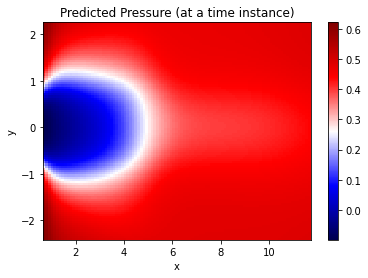

In [25]:
p_pred=np.reshape(p_pred,(10000,200))
p_plot=p_pred[:,180]
#print(p_plot.shape)
p_plot=np.reshape(p_plot,(100,100))
plt.pcolor(x,y,p_plot,cmap='seismic')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted Pressure (at a time instance)')
plt.colorbar()


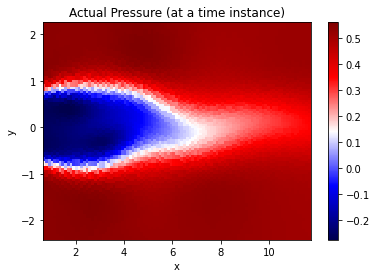

In [26]:
p_tr=np.reshape(p_test,(10000,200))
p_plot=p_tr[:,180]
p_plot=np.reshape(p_plot,(100,100))
plt.pcolor(x,y,p_plot,cmap='seismic')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Actual Pressure (at a time instance)')
plt.colorbar()

In [ ]:
p_pred=np.reshape(u_pred,(10000,200))
p_plot=p_pred[:,10]
#print(p_plot.shape)
p_plot=np.reshape(p_plot,(100,100))
plt.pcolor(x,y,p_plot,cmap='seismic')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted Pressure (at a time instance)')
plt.colorbar()
